<a href="https://colab.research.google.com/github/IDCE-MSGIS/lab-4-zoning-maps-pandas-mlazarz/blob/main/CompProgLab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
'''
Author:  Mitchell Lazarz
Version:  Python 3--Jupytor Notebooks
Creation Date:  12 November 2020
Description:  This script uses geopanda, spatialindex, shapely, and rtree modules 
to merge a shapefile of Public Urban Developments (PUDs) in Washington D.C. with .csv tables 
of affordable housing locations and zoning classifications.  The shapefile and affordable
housing table are converted to geodataframes, joined, then merged with the zoning
classification table.  A map of PUDs showing zoning classification and a map of PUDs
that support affordable housing are displayed.  The merged geodataframe is then exported
as a shapefile to a personal Google Drive folder.
'''


# Add GIS packages geopandas, spatialindex, and rtree to the Google Colab environment
!pip install geopandas
!apt-get install -y libspatialindex-dev # spatialindex supports geopandas operations
!pip install rtree # rtree supports geopandas operations

# Import packages
import pandas as pd  # pandas is imported as pd to provide interface for interacting with tabular data
import geopandas as gpd  # geopandas is imported as gpd which combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # shapely.geometry is imported to convert text data into points, lines, and polygons
from shapely import wkt  # wkt, "well known text", component is imported from shapely which allows for interchange across GIS programs
import rtree  # rtree is imported which supports geospatial joining

     |████████████████████████████████| 972kB 12.2MB/s 
     |████████████████████████████████| 6.5MB 30.5MB/s 
     |████████████████████████████████| 14.8MB 325kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 12 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 0s (5,593 kB/s)
Selecting previously

In [3]:
# Google Colab is connected to Google Drive
from google.colab import drive # drive is imported from google.colab
drive.mount('/content/gdrive') # Google Colab is connected to personal Google Drive
root_path = 'gdrive/My Drive/GIS/' # The root path is set to GIS folder in Google Drive containing data

Mounted at /content/gdrive


In [4]:
# Planned_Unit_Development__PUDs_.shp, Affordable_Housing.csv, and zoning_crosswalk.csv are assigned to variables
puds = gpd.read_file(root_path+'Input/Planned_Unit_Development__PUDs_.shp', crs = {'init' :'epsg:4326'}) # puds.shp is read as a geodataframe using an initial coordinate system, epsg:4326
aff = pd.read_csv(root_path+'Input/Affordable_Housing.csv') # Affordable housing table is read and assigned to variable, aff
crosswalk = pd.read_csv(root_path+'Input/zoning_crosswalk.csv') # Zoning crosswalk table is read and assigned to variable, crosswalk

In [20]:
# Incremental development:  These lines use .sample and .info methods to display information from pud shapefile, aff table, and crosswalk table.
# puds.sample(3)
# aff.info()
# crosswalk.info()

,Zone,Count,Zone_Cat
50,R-5-E,1,Residential
7,"C-3-A, CR",10,Commercial
5,R-5-A,13,Residential
19,C-2-C,3,Commercial


In [7]:
# Geometry field is added to aff table and converted to geodataframe
aff['geometry'] = aff.apply(lambda row: Point(row.X, row.Y), axis=1) # A geometry column is added to the aff table indicating 'Point' geometry type and x and y rows
aff = gpd.GeoDataFrame(aff, crs={'init' :'epsg:4326'}) # aff table is assigned to a geodataframe with initial coordinate system epsg:4326

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [15]:
# Incremental development:  aff geodataframe is sampled to check for new geometry column
# aff.sample(1)

,X,Y,OBJECTID,MAR_WARD,ADDRESS,PROJECT_NAME,STATUS_PUBLIC,AGENCY_CALCULATED,TOTAL_AFFORDABLE_UNITS,LATITUDE,LONGITUDE,AFFORDABLE_UNITS_AT_0_30_AMI,AFFORDABLE_UNITS_AT_31_50_AMI,AFFORDABLE_UNITS_AT_51_60_AMI,AFFORDABLE_UNITS_AT_61_80_AMI,AFFORDABLE_UNITS_AT_81_AMI,CASE_ID,ADDRESS_ID,XCOORD,YCOORD,FULLADDRESS,GIS_LAST_MOD_DTTM,geometry
382,-77.025937,38.938431,1549,Ward 4,"930 Randolph Street Northwest, Washington, Dis...",Petworth Station Feb 2018,Under Construction,DHCD,84,38.938423,-77.025935,0,10,74,0,0,NaN,225073.0,397751.51,141170.91,930 RANDOLPH STREET NW,2020/11/02 04:00:31+00,POINT (-77.02594 38.93843)


In [16]:
# puds and aff geodataframes are joined based on a geographic intersection operator and assigned to puds_aff variable
puds_aff = gpd.sjoin(puds, aff, op='intersects', how='left')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +init=epsg:4326 +type=crs

  


In [17]:
# Incremental development:  Spatial join is confirmed by displaying puds_aff variable information
# puds_aff.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 305 entries, 0 to 297
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   OBJECTID_left                  305 non-null    int64   
 1   PUD_NAME                       305 non-null    object  
 2   PUD_WEB_UR                     305 non-null    object  
 3   PUD_CHANGE                     303 non-null    object  
 4   PUD_ZONING                     305 non-null    object  
 5   PUD_STATUS                     305 non-null    object  
 6   PUD_CASE_N                     305 non-null    object  
 7   GLOBALID                       305 non-null    object  
 8   WARD                           305 non-null    object  
 9   SHAPEAREA                      305 non-null    int64   
 10  SHAPELEN                       305 non-null    int64   
 11  geometry                       305 non-null    geometry
 12  index_right                 

In [21]:
# The puds_aff dataframe is merged with the Zoning crosswalk table to define the zoning catagories and assigned to puds_info variable
puds_info = puds_aff.merge(crosswalk[['Zone_Cat']], how='left', left_on='PUD_ZONING', right_on=crosswalk['Zone'])

In [24]:
# Print statements displaying the total number of PUDs and the total number of PUDs with affordable housing

print(f"Total count of PUDs: {puds_info.shape[0]}")
print(f"Count PUDs offering Affordable Housing: {puds_info.loc[~puds_info.PROJECT_NAME.isna()].shape[0]}")

Total count of PUDs: 305
Count PUDs offering Affordable Housing: 78


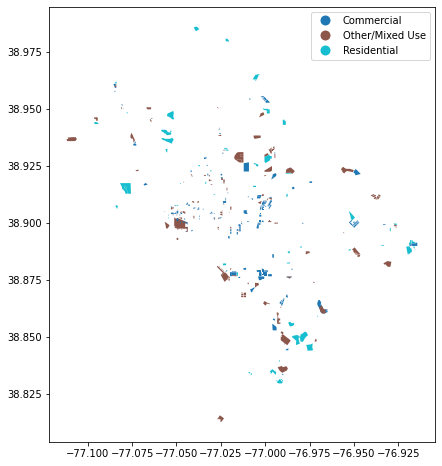

In [ ]:
# All PUDs are mapped by zoning category
puds_info.plot(column='Zone_Cat', legend=True, figsize=(16,8));

/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:573: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


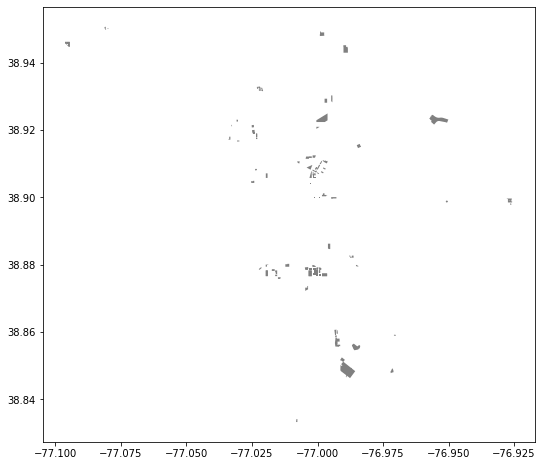

In [ ]:
# All PUDs that offer affordable housing are mapped
puds_info[puds_info['TOTAL_AFFORDABLE_UNITS']>0].plot(column='TOTAL_AFFORDABLE_UNITS', color='grey', figsize=(16,8));

In [ ]:
# Export puds_info geodataframe as shapefile within Colab environment
puds_info.to_file('puds_info.shp')

# Copy pud_info shapefile components from Colab environment to Google Drive using bash script
!cp puds_info.cpg 'gdrive/My Drive/GIS/Output'
!cp puds_info.dbf 'gdrive/My Drive/GIS/Output'
!cp puds_info.prj 'gdrive/My Drive/GIS/Output'
!cp puds_info.shp 'gdrive/My Drive/GIS/Output'
!cp puds_info.shx 'gdrive/My Drive/GIS/Output'